# Necessary  Libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from re import split
from wordcloud import WordCloud as WC
#from PIL import Image#for mask on wordcloud
%matplotlib inline

# Methods

## METHOD 1 INITIALISATION OF DATA: init()

In [71]:
def init():
    global df
    main_df = pd.read_excel('C:/Users/user/Desktop/MBA/DATASET/Online Retail.xlsx')#insert file path
    df=copy.deepcopy(main_df)

## METHOD 2 INFORMATION ABOUT DATA: info()

In [72]:
def info():#basic information about data we are dealing with
    print("\n\t Info about Data \t\n",df.describe(),df.info())
    print("\n\t Info about NaN data \t\n",df.isna().any())
    print("\n\t NaN values present in columns \t\n",df.isna().sum())
    detail=df.groupby('StockCode').describe().sort_values([('Quantity','count')],ascending=False)
    print("\n\t Detailed Data Information \t\n",detail)

## METHOD 3 CLEANING DATA: clean()

In [73]:
def clean():
    # cleaning nan values from customer number data start #
    df['CustomerID']=df['CustomerID'].fillna(-1)
    df['CustomerID']=df['CustomerID'].astype(int)
    df['CustomerID']=df['CustomerID'].astype(str)
    df['CustomerID']=df['CustomerID'].replace('NAN',np.nan).replace('NaN',np.nan).replace('nan',np.nan).replace('-1',np.nan)
    # cleaning customer data from customer number data end #
    
    # converting columns to string start #
    df[['InvoiceNo','StockCode','Description','Country']]=df[['InvoiceNo','StockCode','Description','Country']].apply(lambda x: x.astype(str).str.upper())
    # converting columns to string end #
    
    # dropping and replacing unnecessary data start #
    df['InvoiceNo']=df['InvoiceNo'].str.strip()
    df['Country']=df['Country'].str.strip()
    df['Description']=df['Description'].str.strip()
    df['StockCode']=df['StockCode'].str.strip()
    df['Description']=df['Description'].str.replace("\\","").str.replace("+","").str.replace(",","").str.replace(".","").str.replace("-","_").str.replace("*","")
    df['Description']=df['Description'].apply(lambda x: ''.join(a.capitalize() for a in split('([^a-zA-Z0-9])',x) if a.isalnum()))
    # dropping and replacing unnecessary data end #
    
    buzz='BANK CHARGES|C2|DCGSSBOY|DCGSSGIRL|GIFT|ALL|POST|CODED|MISMATCH|MISSED|TRANSIT|SAMPLES|TRADING|ASIDE|INCORRECT|JOHN LEWIS|ADD|DEBT|CREDIT|MANUAL|ALAN|FEE|RETURN|DAMAGE|LOST|ERROR|SPOIL|BROKE|\?|FOUND|ADJUST|AMAZON|DISCOUNT|DOT|CARGO'
    df.drop(df.loc[df['Description'].str.contains(buzz,case=False,regex=True)].index,inplace=True)
    df.drop(df.loc[df['StockCode'].str.contains(buzz,case=False,regex=True)].index,inplace=True)
    df.drop(df.loc[df['InvoiceNo'].str.get(0)=='C'].index,inplace=True);#cancelled purchases
    df.drop(df.loc[df['Quantity']<=0].index,inplace=True)#negative quantity
    df.drop(df.loc[df['UnitPrice']<=0.00].index,inplace=True)#negative purchases
    
    #saving file start #
    df.to_excel('CLEANED_ONLINE_RETAIL.xlsx',index=False)
    #saving file end #

## METHOD 4 WORDCLOUD: generate_wordcloud()

In [74]:
def generate_wordcloud():
    #selection of data tuples greater than median on total amoungt purchased start#
    total_purchase=df[['StockCode','Quantity']]
    total_purchase=total_purchase.groupby('StockCode')
    total_purchase=total_purchase.sum()
    total_purchase=total_purchase.sort_values(by='Quantity',ascending=False)
    total_purchase=total_purchase[total_purchase.Quantity > total_purchase['Quantity'].median()]
    #selection of data tuples greater than median on total amoungt purchased end#
    items=df[['StockCode','Description']].merge(total_purchase,on='StockCode',how='inner')
    items=items[['StockCode','Description']]
    test=items.groupby('StockCode')
    count=test.count()
    count.sort_values(by='Description',ascending=False,inplace=True)
    count=count[count['Description']>=float(count.quantile(q=0.5))]#selecting 50th quantile and greater
    count=items['Description'].astype(str)
    string=''# adding all description to a string
    for val in df['Description']:
        if (val=='NAN' or val=='NaN' or val==np.NaN) != 1:
            string+=val+' '
    #mask=np.array(Image.open('C:/Users/user/Desktop/DS/supermarket/4.jpg'))
    wordcloud=WC(width=800,height=800, background_color='white',scale=1).generate(string)#generation of wordcloud
    plt.figure(figsize=(10,10),facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('WordCloud.jpeg')

## METHOD 5 RELATION BETWEEN PURCHASE FREQUENCY AND PRICE: relation()

In [75]:
def relation():
    #selection of data tuples greater than median on total amoungt purchased start#
    total_purchase=df[['StockCode','Quantity']]
    total_purchase=total_purchase.groupby('StockCode')
    total_purchase=total_purchase.sum()
    total_purchase=total_purchase.sort_values(by='Quantity',ascending=False)
    total_purchase=total_purchase[total_purchase.Quantity > total_purchase['Quantity'].median()]
    total_purchase=total_purchase.reset_index()
    #selection of data tuples greater than median on total amoungt purchased end#
    #selecting top 10 and least 10 sold products as per quantity sold
    most=total_purchase[:10]
    least=total_purchase[-10:]
    final=pd.merge(most,least,on='StockCode',how='outer')
    final=final['StockCode'].to_frame()
    #intersection to a single frame
    new=pd.merge(final,df,on='StockCode',how='inner')
    new=new[['StockCode','UnitPrice','Quantity']]
    new=new.groupby('StockCode')['UnitPrice'].value_counts().to_frame()
    new=new.rename(columns={'UnitPrice':'No of times Bought'})
    new=new.sort_index(ascending=True)
    new['Frequency']=new['No of times Bought']/373#total time period of consideration in days for quantity sold in a day,frequency of buying in days
    new=new.reset_index()
    for key,grp in new.groupby('StockCode'):
        grp.plot(kind='bar',y='Frequency',x='UnitPrice',label=key,figsize=(10,10))
        plt.xlabel("UnitPrice")
        plt.ylabel("Frequency")
        save=str(key+'.jpeg')
        plt.savefig(save)

## METHOD 6 LINE GRAPH OF PRODUCT AND AVERAGE ORDER QUANTITY: graph()

In [76]:

def line():
    pquan = df
    pquan = pquan.dropna()
    plt.rcParams['figure.figsize'] =(20,10)
    pquan.groupby('Description')['Quantity'].sum()[:100].plot(kind='line',linewidth=2)
    plt.show()
    df.groupby('Description')['Quantity'].sum()[:1000].plot(kind='line',linewidth=5)
    plt.show()
    
def graph_line():
    Grp=df.groupby('Description')['UnitPrice'].value_counts().to_frame()
    Grp1=df.groupby('Description')['Quantity'].sum().to_frame()
    Grp=Grp.groupby(['Description']).sum()
    Grp=Grp.rename(columns={'UnitPrice':'No. of times Bought'})
    Grp1['No. of times Bought']=Grp['No. of times Bought']
    Grp1['Average Qty_Ordered']=Grp1['Quantity']/Grp1['No. of times Bought']
    Grp1.drop(Grp1.loc[Grp1['Average Qty_Ordered']<Grp1['Average Qty_Ordered'].median()].index,inplace=True)
    maximum=Grp1.nlargest(10,'Average Qty_Ordered')
    minimum=Grp1.nsmallest(10,'Average Qty_Ordered')
    g=maximum.append(minimum)
    g=g.reset_index()
    g.plot(kind='line',y='Average Qty_Ordered',x='Description',figsize=(10,10))
    plt.xlabel('Description')
    plt.ylabel('Avg Ordered_Qty')
    save=str('Avg Ordered'+' .jpeg')
    plt.savefig(save)
    plt.show()
    
    
def graph_bar():
    Grp=df.groupby('Description')['UnitPrice'].value_counts().to_frame()
    Grp1=df.groupby('Description')['Quantity'].sum().to_frame()
    Grp=Grp.groupby(['Description']).sum()
    Grp=Grp.rename(columns={'UnitPrice':'No. of times Bought'})
    Grp1['No. of times Bought']=Grp['No. of times Bought']
    Grp1['Average Qty_Ordered']=Grp1['Quantity']/Grp1['No. of times Bought']
    Grp1.drop(Grp1.loc[Grp1['Average Qty_Ordered']<Grp1['Average Qty_Ordered'].median()].index,inplace=True)
    maximum=Grp1.nlargest(10,'Average Qty_Ordered')
    minimum=Grp1.nsmallest(10,'Average Qty_Ordered')
    g=maximum.append(minimum)
    g=g.reset_index()
    g.plot(kind='bar',y='Average Qty_Ordered',x='Description',figsize=(10,10))
    plt.xlabel('Description')
    plt.ylabel('Avg Ordered_Qty')
    save=str('Avg Ordered'+' .jpeg')
    plt.savefig(save)
    plt.show()
    
    
def graph_monthly():
    cp=copy.deepcopy(df.dropna())
    cp=cp.groupby(['InvoiceDate','Description'])['UnitPrice'].value_counts().to_frame()
    cp=cp.rename(columns={'UnitPrice':'Times'})
    cp=cp.reset_index()
    cp=cp[['InvoiceDate','Description','Times']]
    cp=cp.set_index('InvoiceDate')
    cp=cp.groupby(pd.Grouper(freq='1M')).apply(lambda x: x.groupby('Description').sum())
    cpy=copy.deepcopy(df.dropna())
    cpy=cpy.groupby(['InvoiceDate','Description'])['Quantity'].sum().to_frame()
    cpy=cpy.reset_index()
    cpy=cpy.set_index('InvoiceDate')
    cpy=cpy.groupby(pd.Grouper(freq='1M')).apply(lambda x: x.groupby('Description').sum())
    cpy2=pd.merge(cp,cpy,on=['InvoiceDate','Description'],how='inner')
    cpy2['Avg Ordered']=cpy2['Quantity']/cpy2['Times']
    cpy2=cpy2.reset_index()
    test=cpy2.groupby('Description').sum()
    #selecting most brought products for avg order calculation
    test['Avg Ordered']=test['Quantity']/test['Times']
    test.sort_values(by='Times',ascending=False,inplace=True)
    test=test[:10]
    test=test.reset_index()
    test2=test['Description'].to_frame()
    final_plot=pd.merge(cpy2,test2,on='Description',how='inner')
    
    #individual plots
    def individual():
        for key,grp in final_plot.groupby('Description'):
            grp.plot(kind='line',y='Avg Ordered',x='InvoiceDate',label=key,figsize=(15,15),marker='o')
            save=str(key+' .jpeg')
            plt.savefig(save)
    individual()
    
    #single plot
    def grouped():
        fig,sub=plt.subplots()
        for key,grp in final_plot.groupby('Description'):
            sub=grp.plot(ax=sub,kind='line',y='Avg Ordered',x='InvoiceDate',label=key,figsize=(15,15))
            save=str('Grouped'+' .jpeg')
            plt.savefig(save)
        plt.legend(loc='best')
        #plt.show()
        
    grouped()

## METHOD CALLS: 

In [77]:
init()

In [78]:
info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

	 Info about Data 	
             Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000 None

	 Info a

In [79]:
clean()

In [80]:
info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472609 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      472609 non-null object
StockCode      472609 non-null object
Description    472609 non-null object
Quantity       472609 non-null int64
InvoiceDate    472609 non-null datetime64[ns]
UnitPrice      472609 non-null float64
CustomerID     355586 non-null object
Country        472609 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 32.5+ MB

	 Info about Data 	
             Quantity      UnitPrice
count  472609.000000  472609.000000
mean       10.543453       3.282610
std       164.080837       4.464449
min         1.000000       0.040000
25%         1.000000       1.250000
50%         3.000000       2.100000
75%        11.000000       4.130000
max     80995.000000     649.500000 None

	 Info about NaN data 	
 InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice     

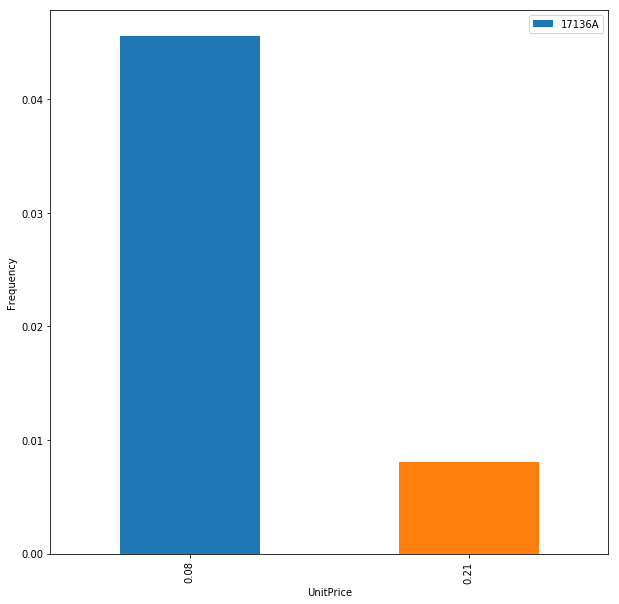

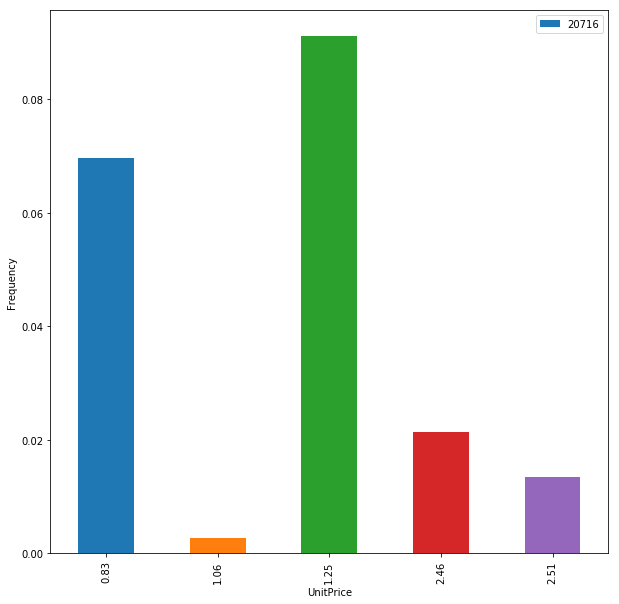

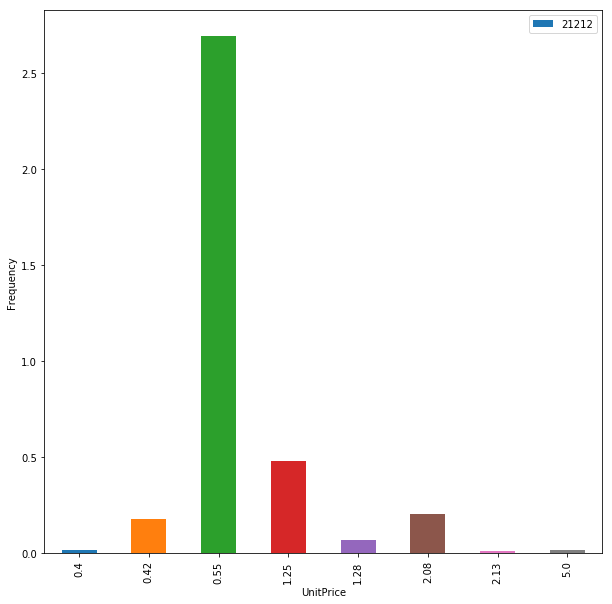

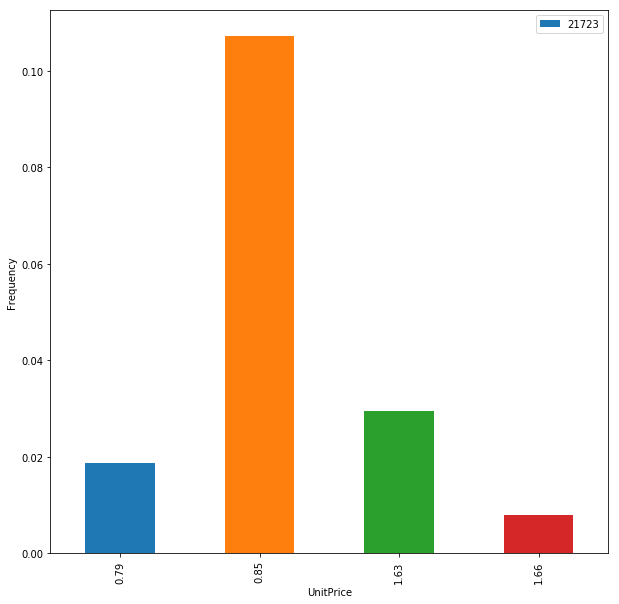

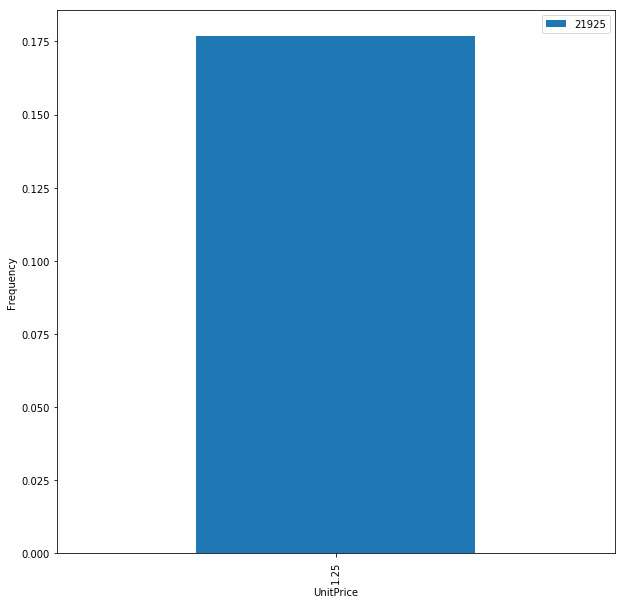

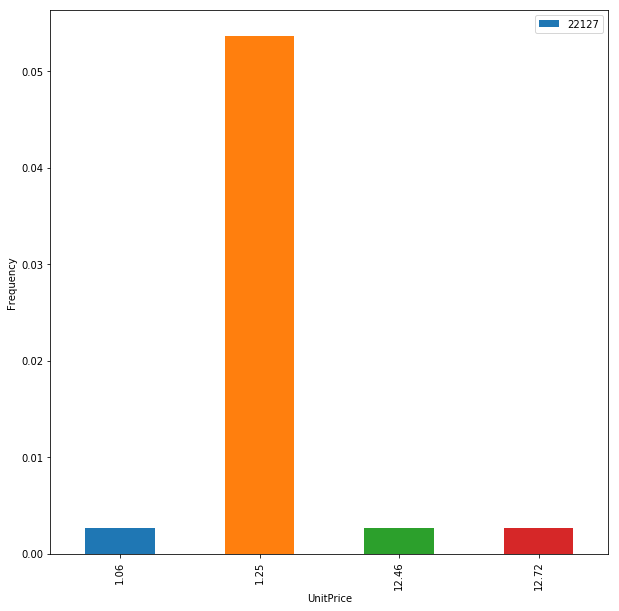

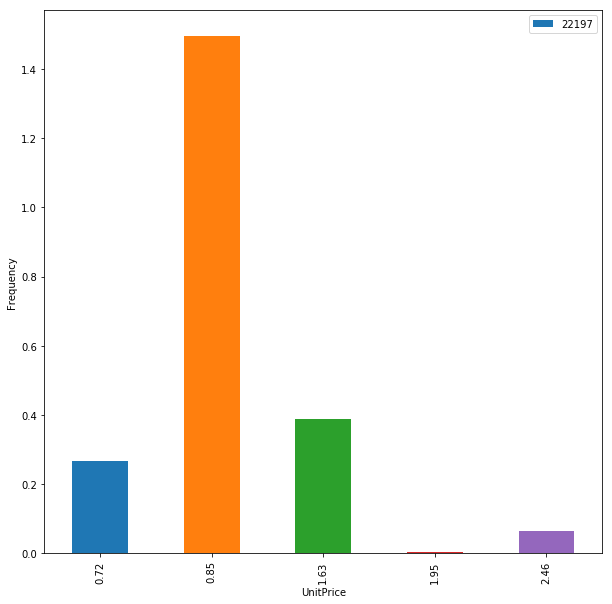

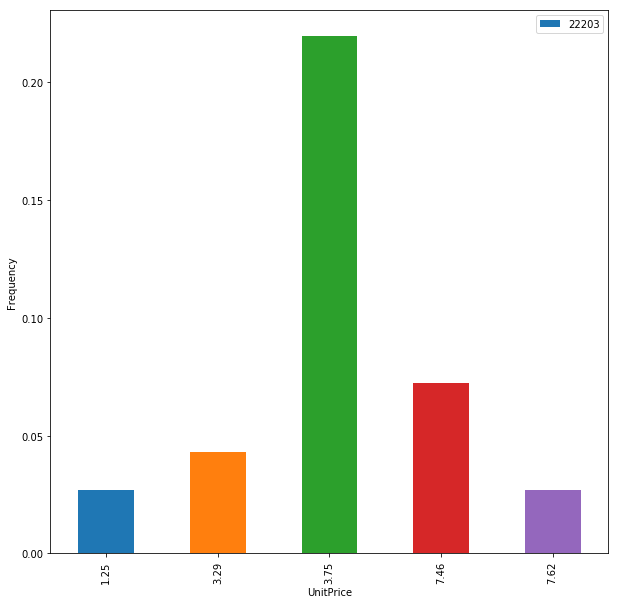

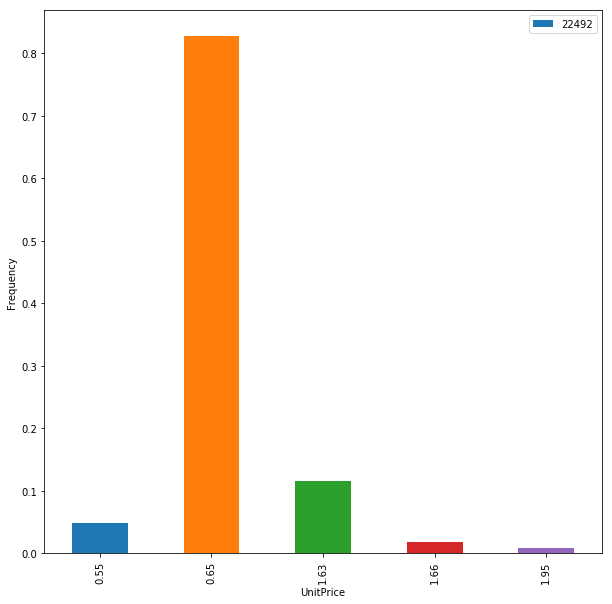

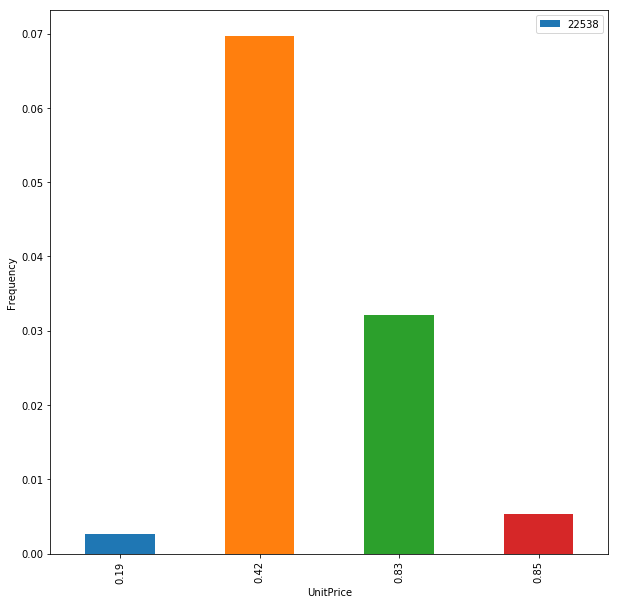

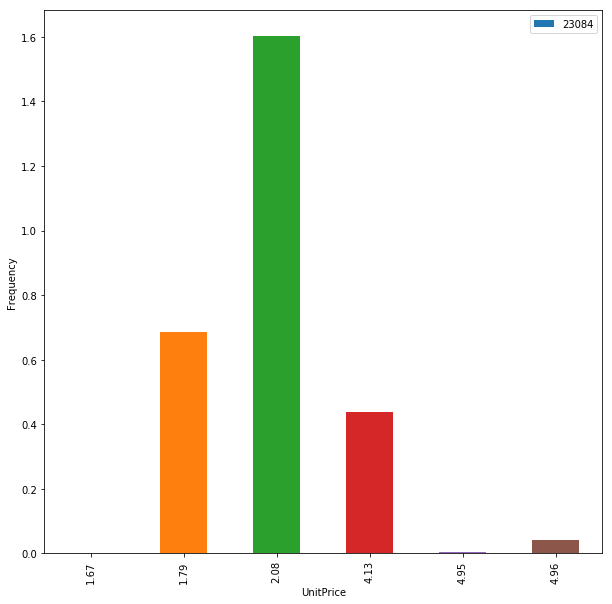

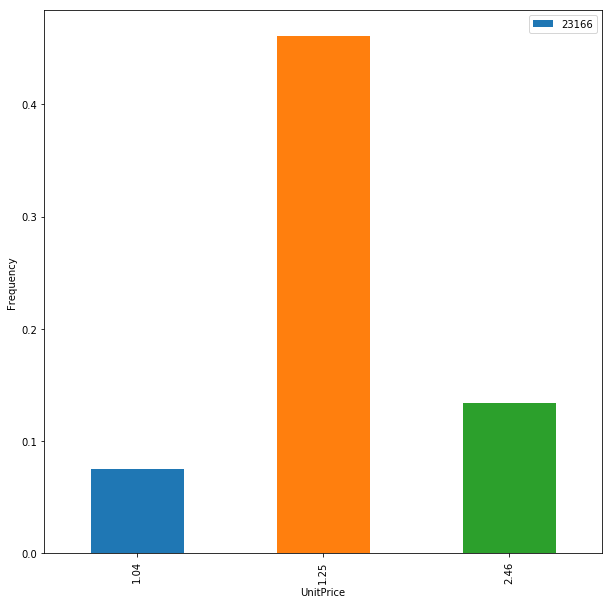

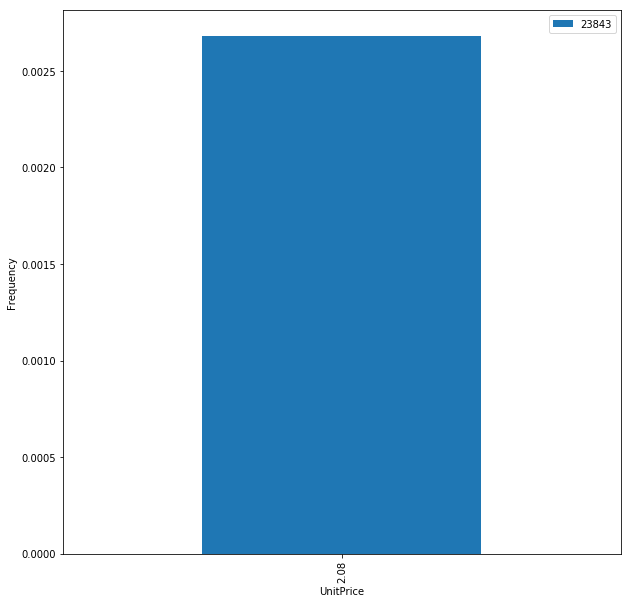

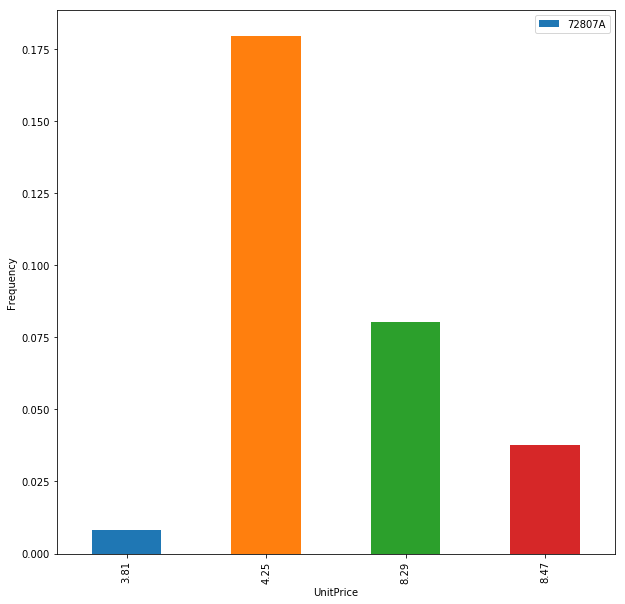

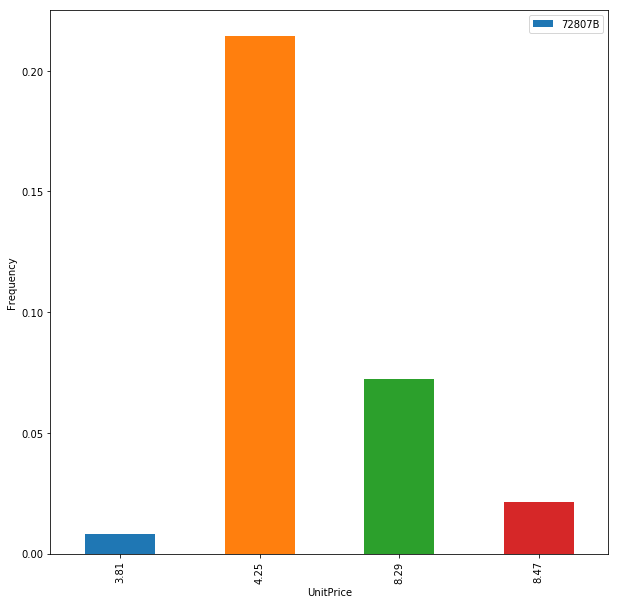

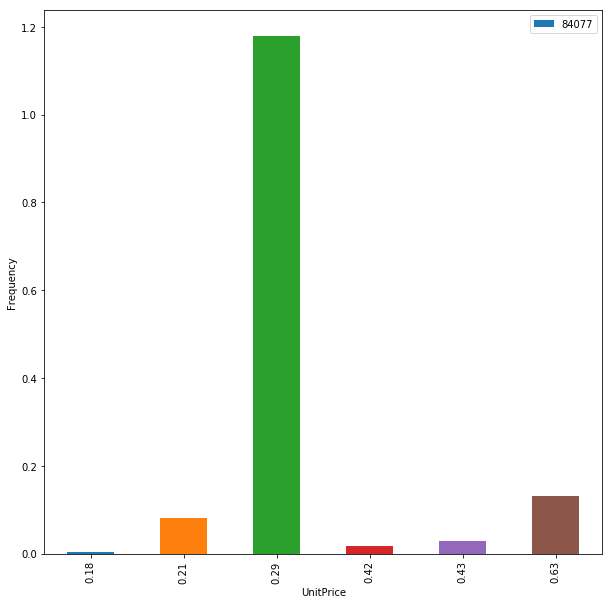

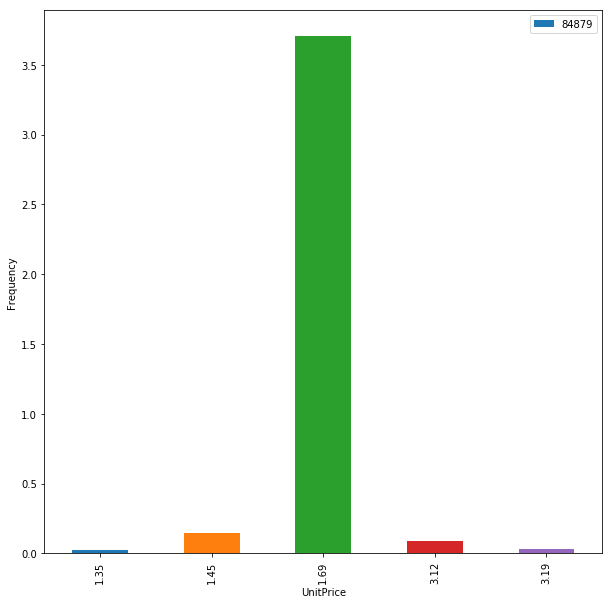

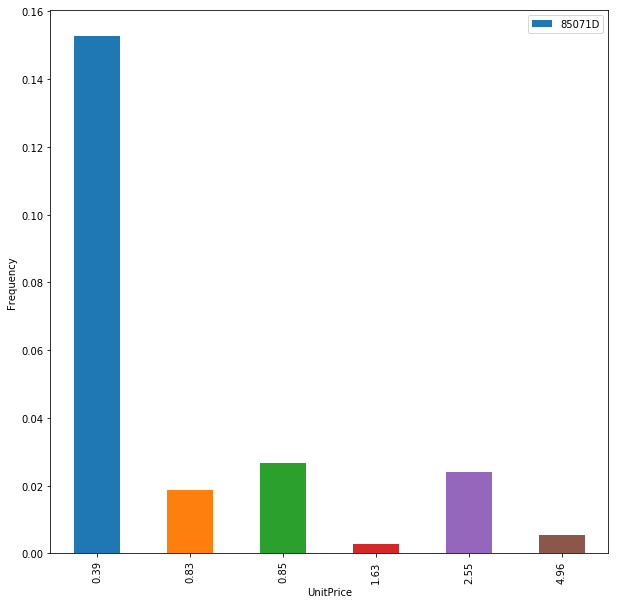

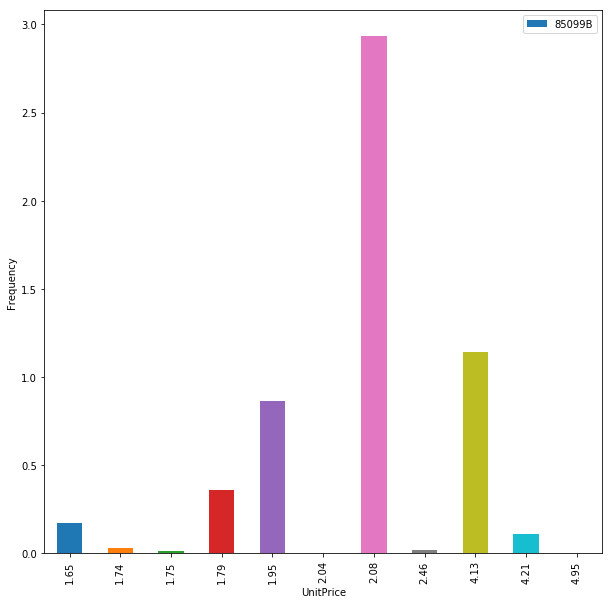

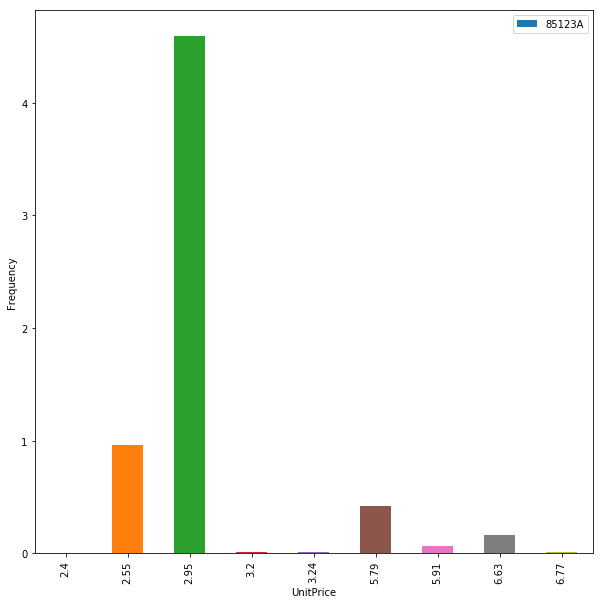

In [81]:
relation()

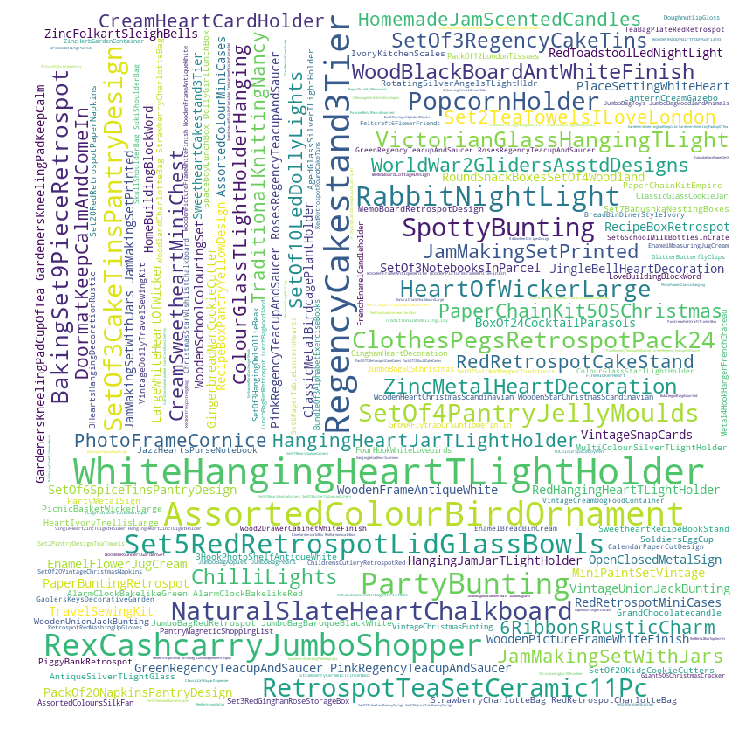

<Figure size 432x288 with 0 Axes>

In [82]:
generate_wordcloud()

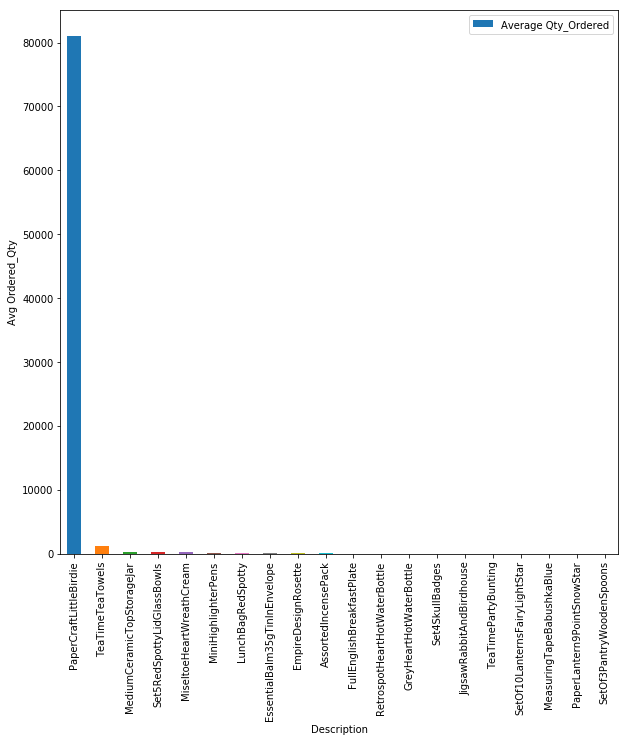

In [83]:
graph_bar()

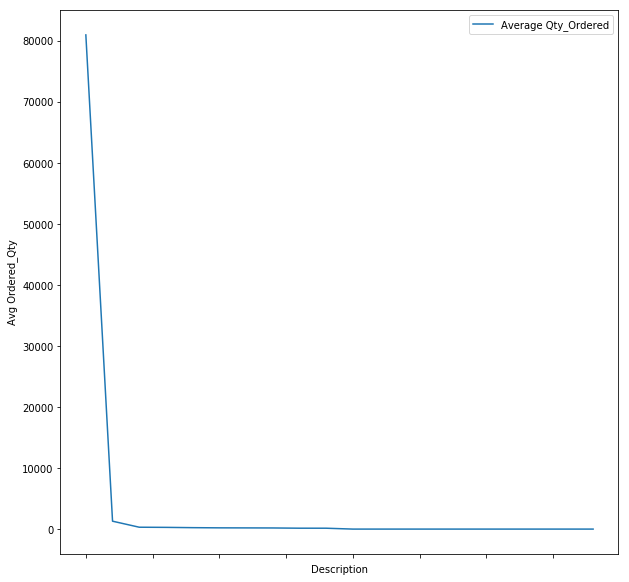

In [84]:
graph_line()

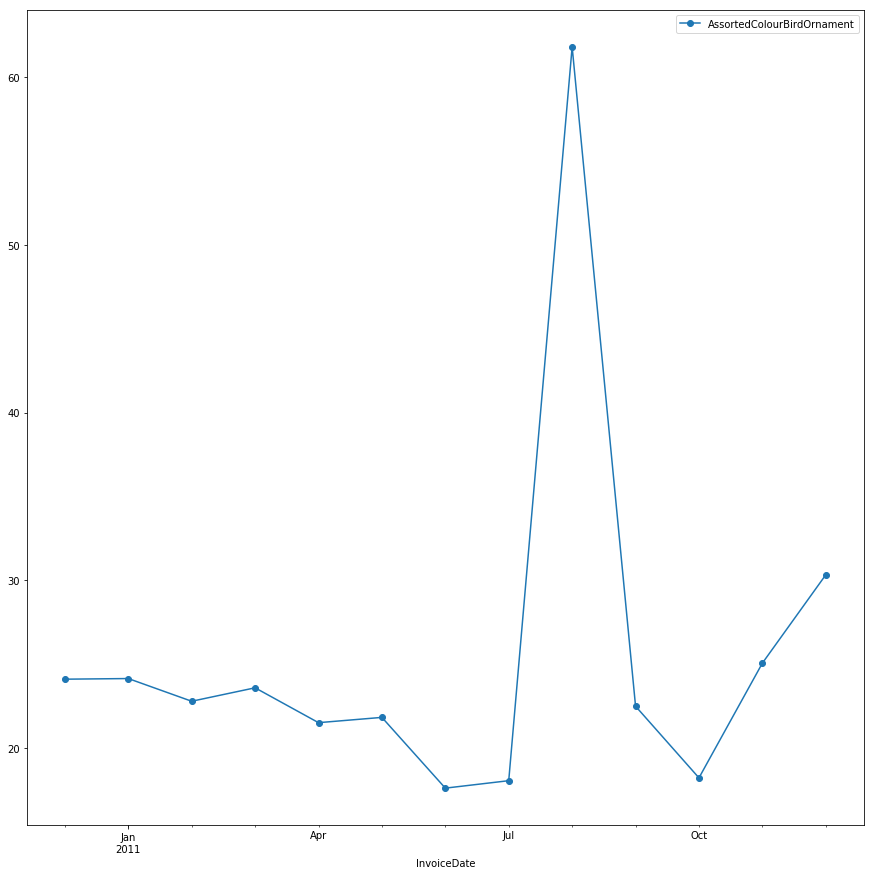

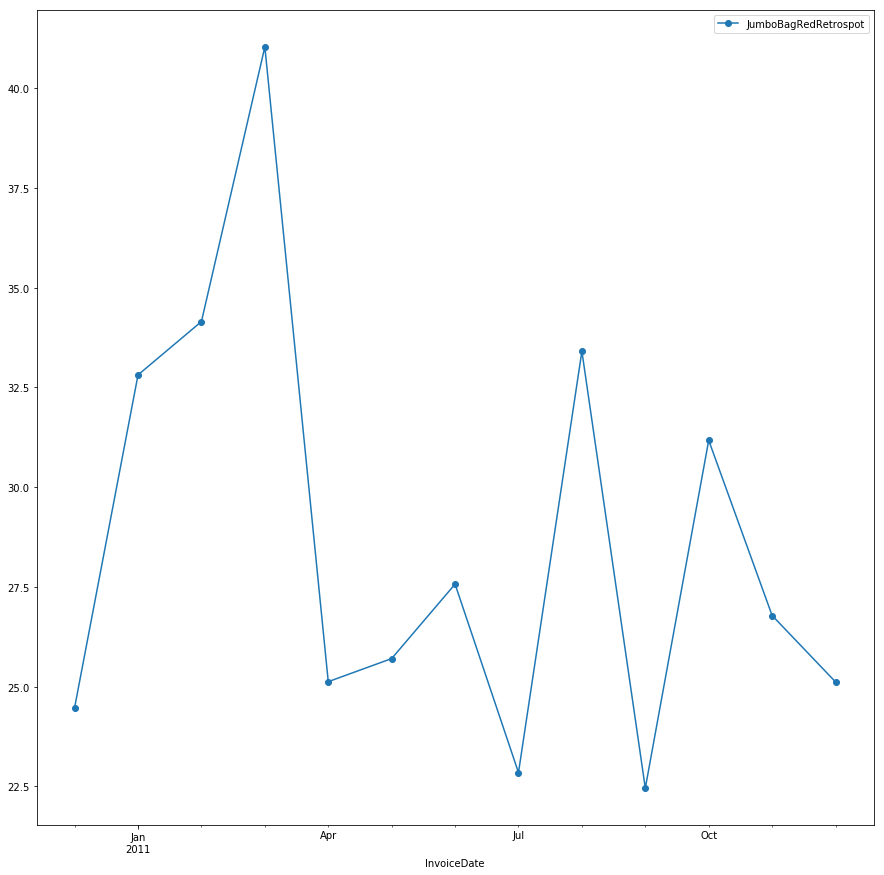

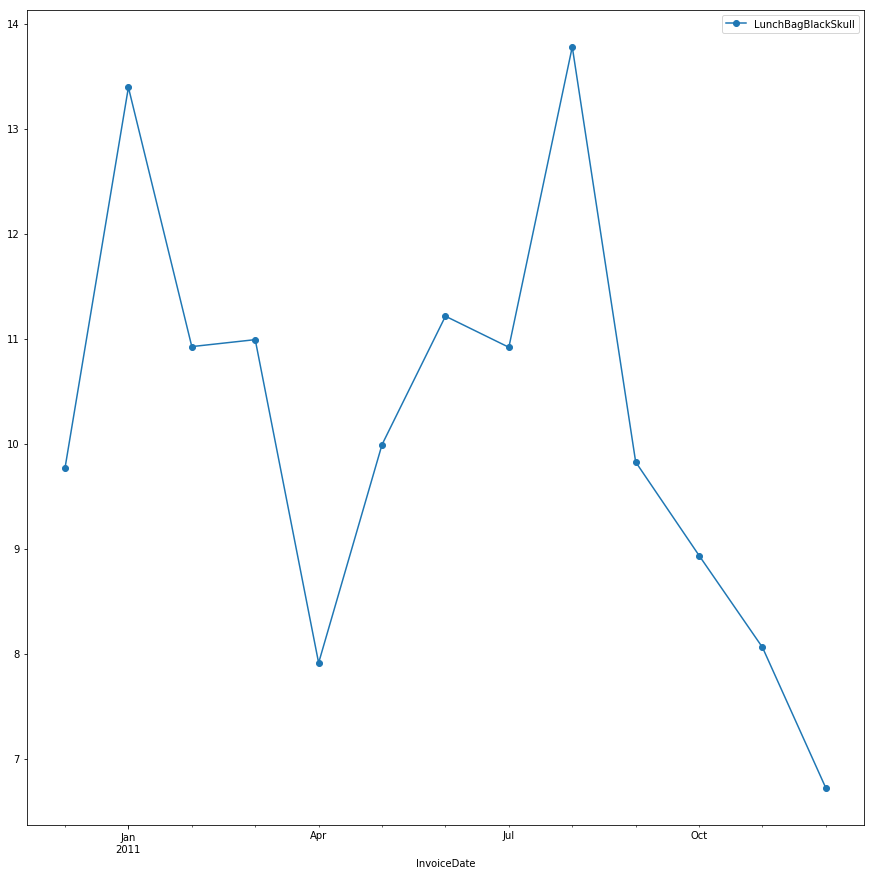

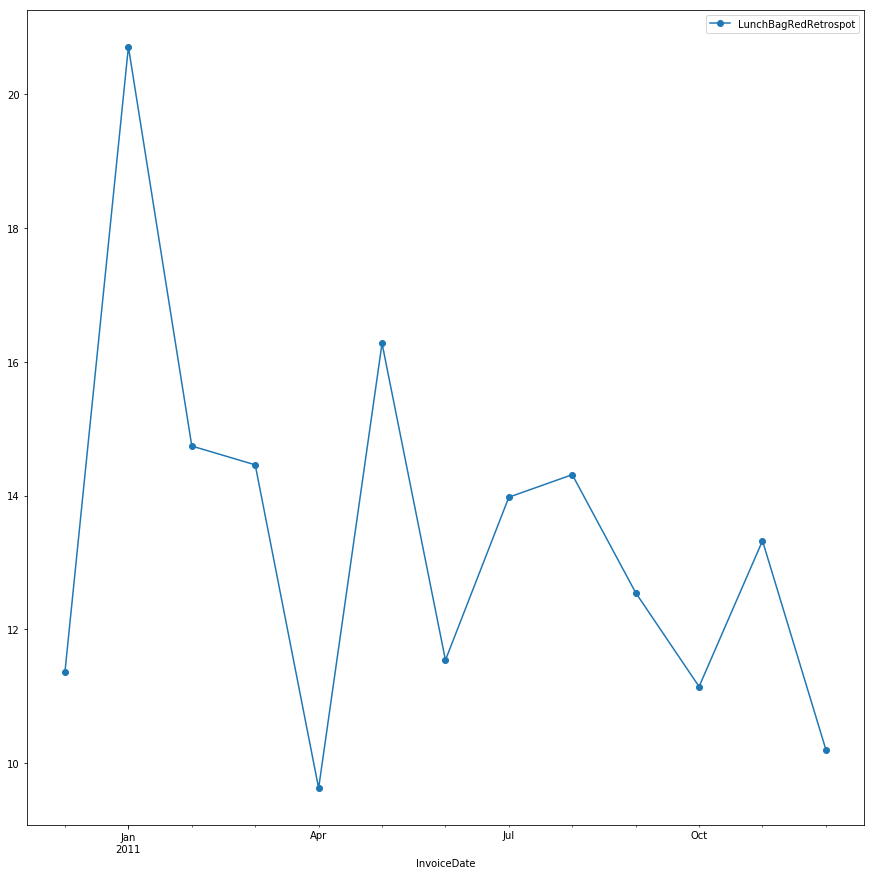

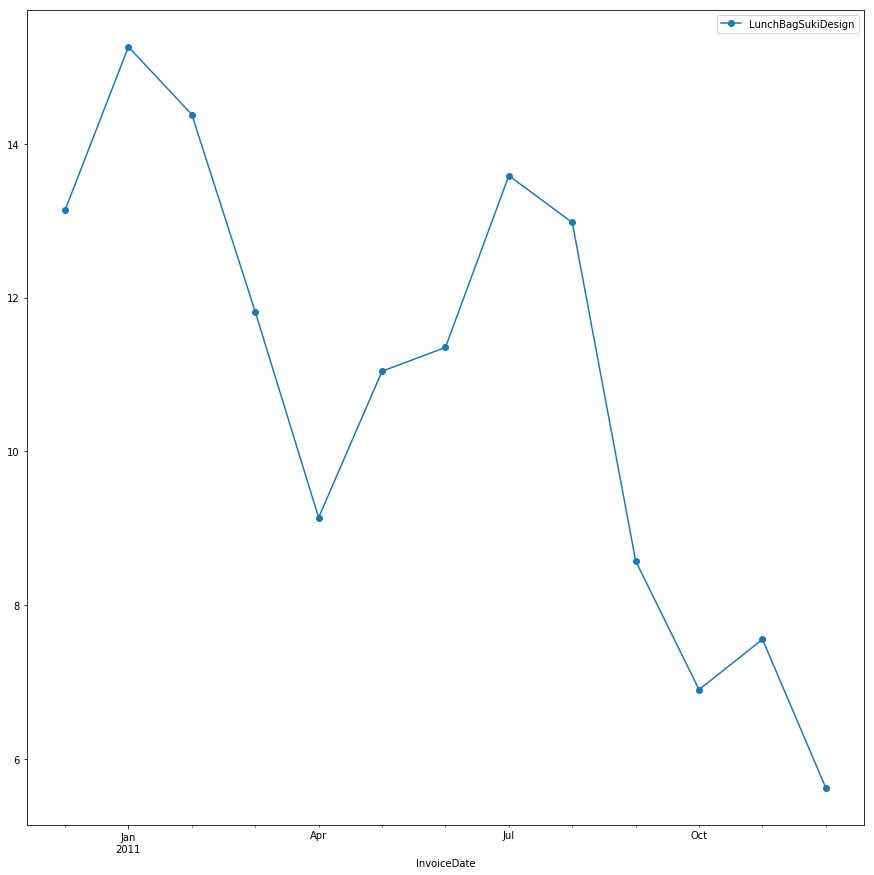

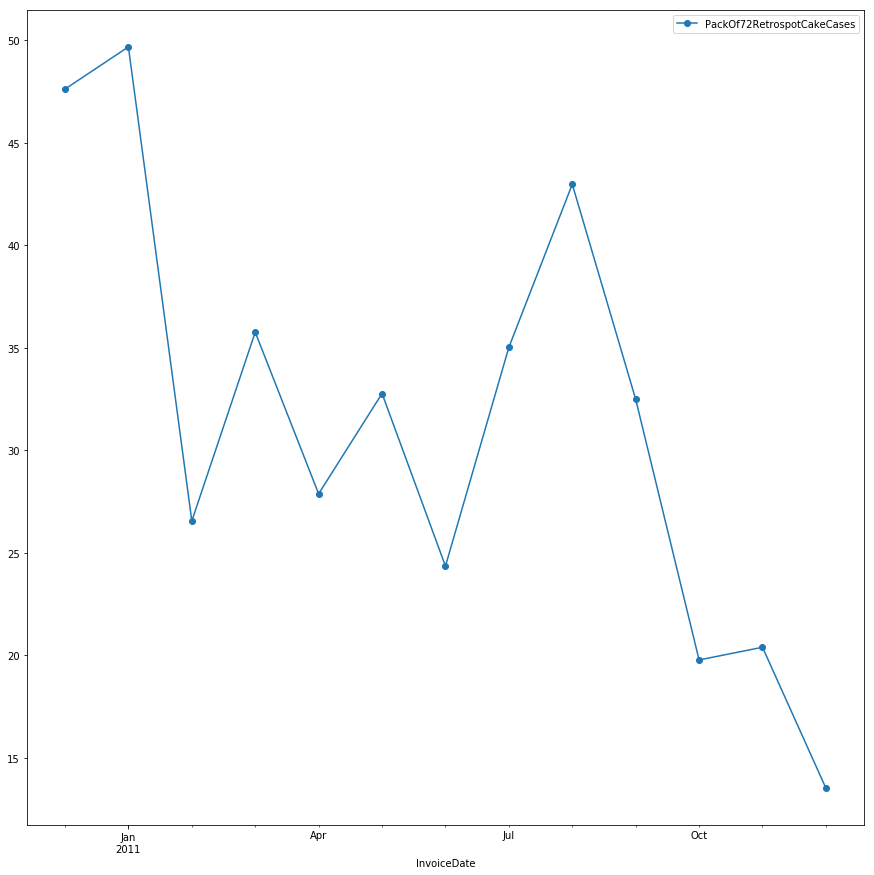

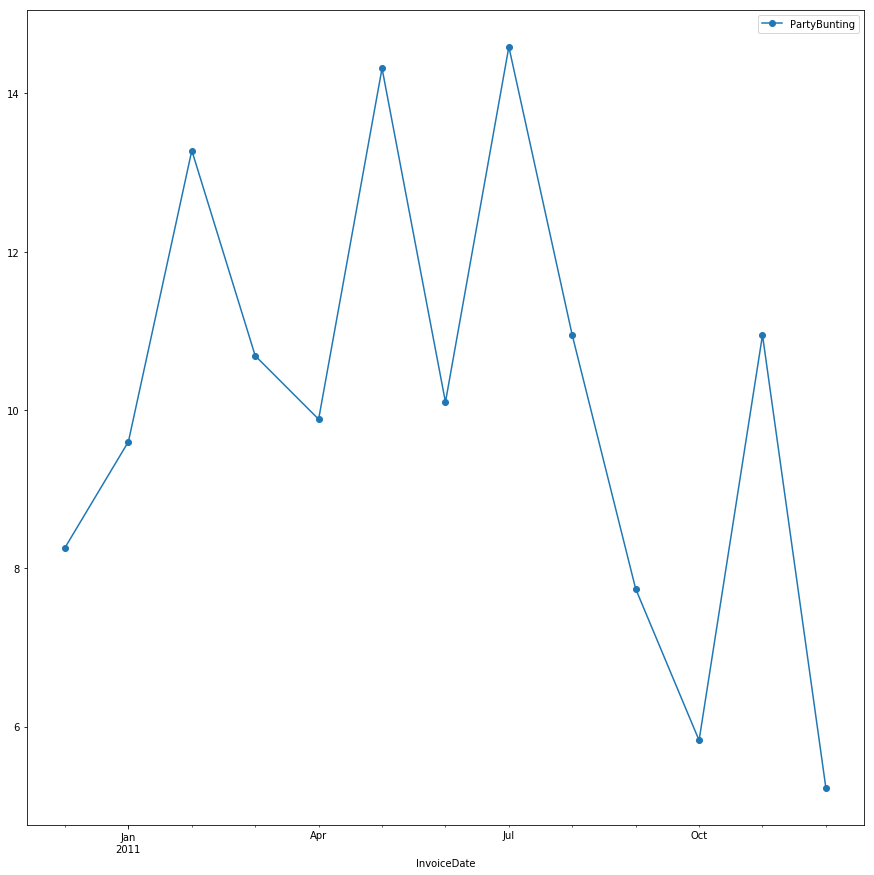

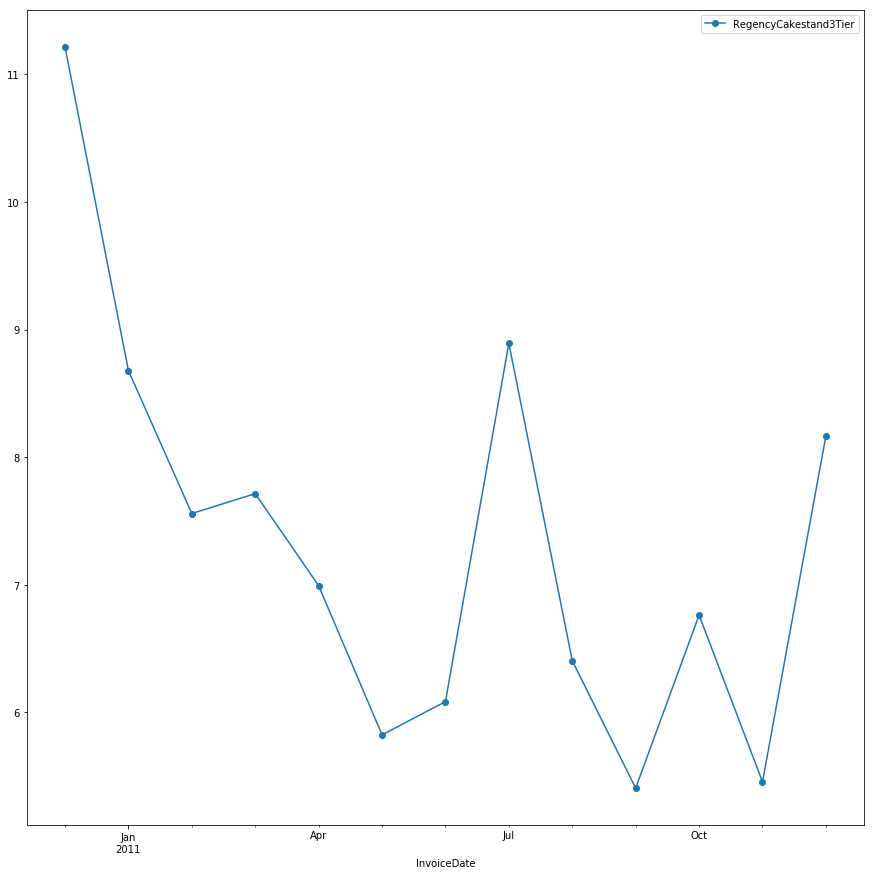

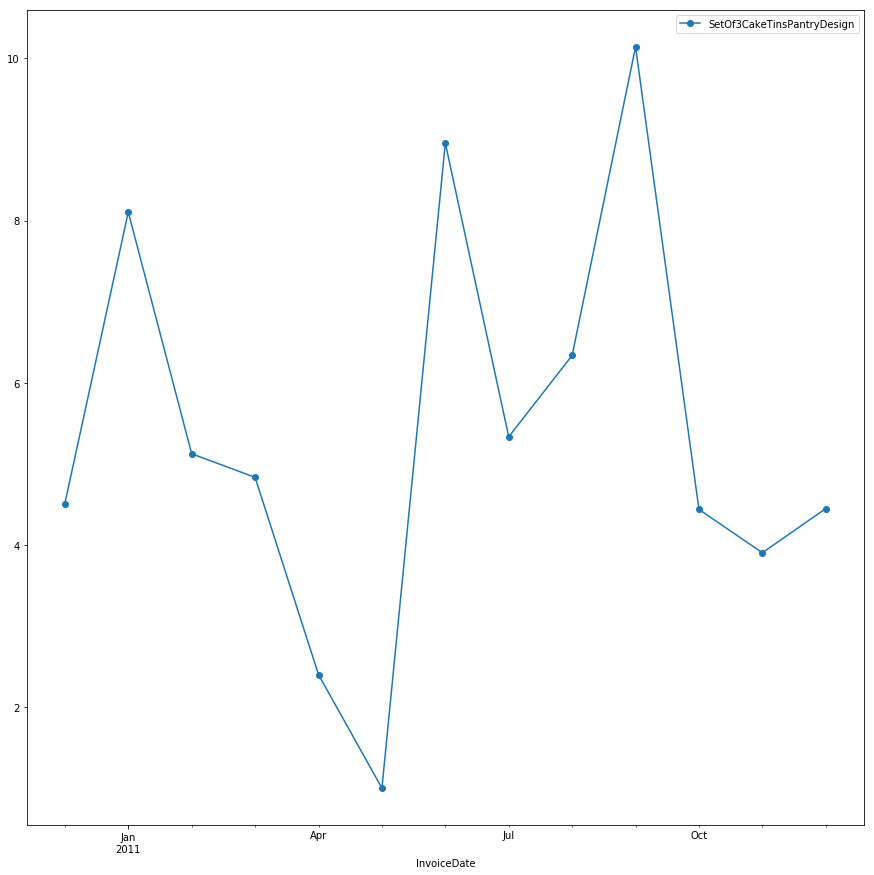

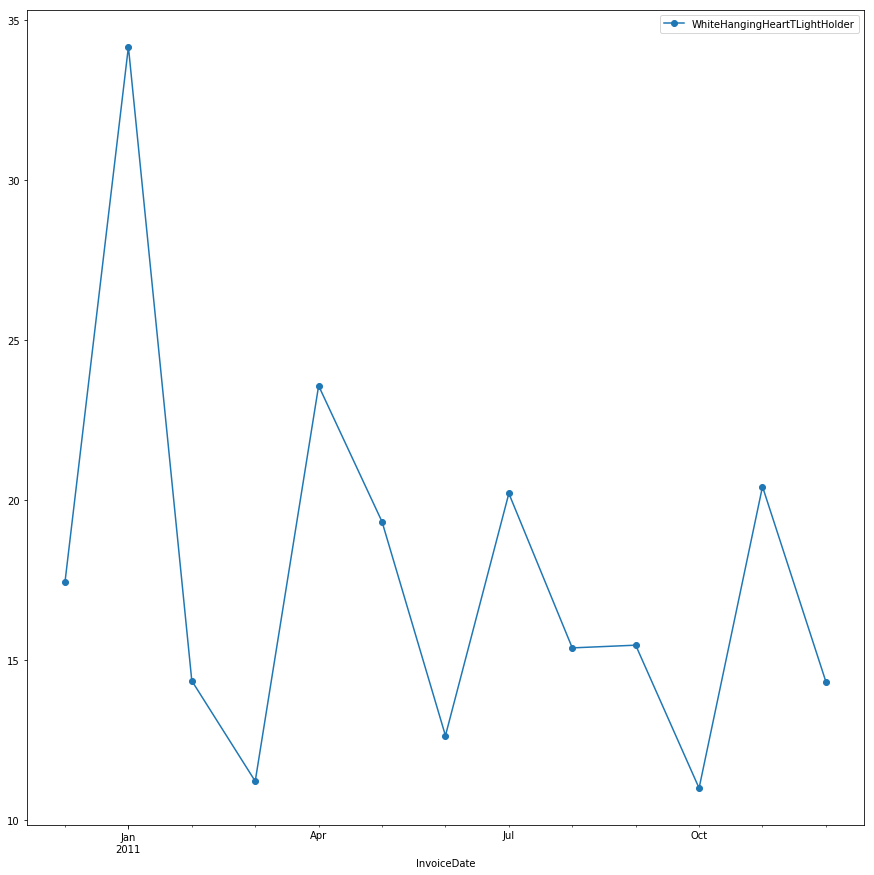

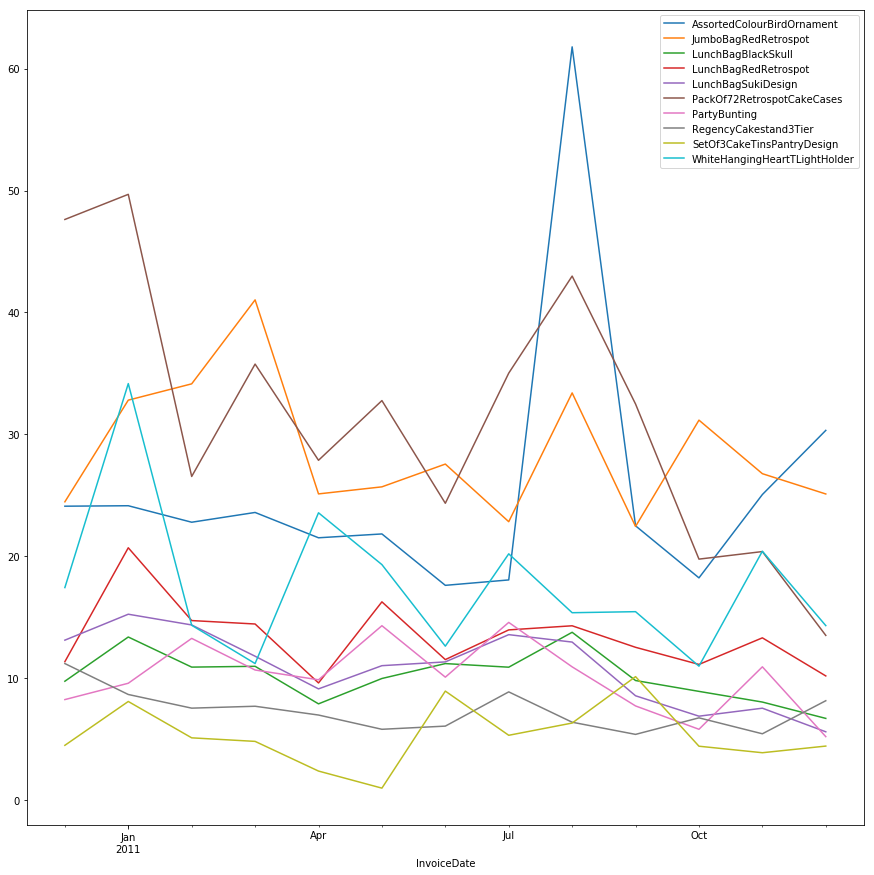

In [85]:
graph_monthly()

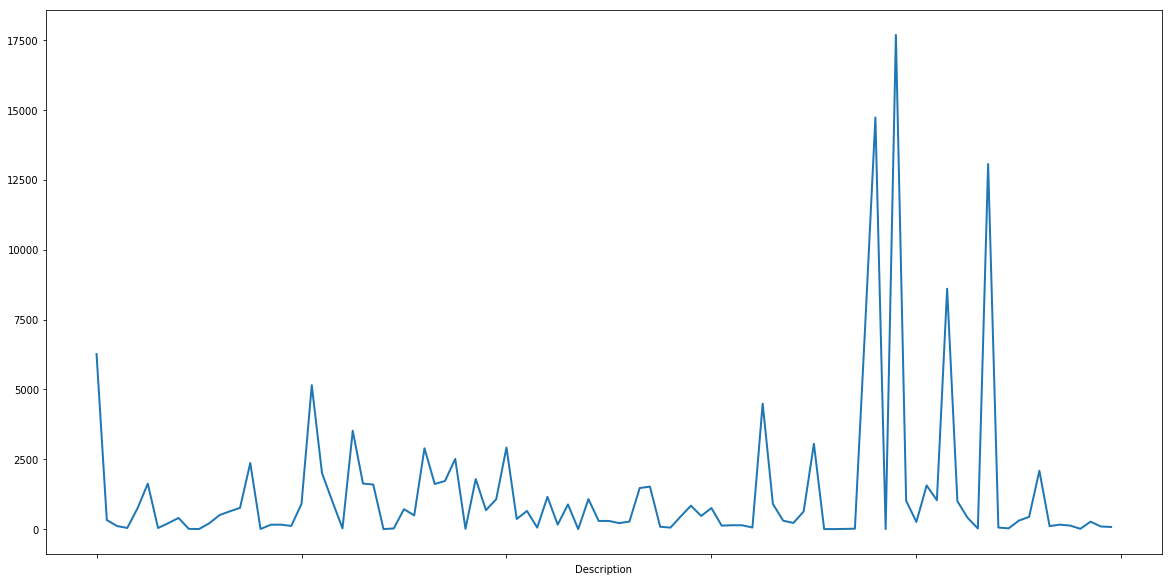

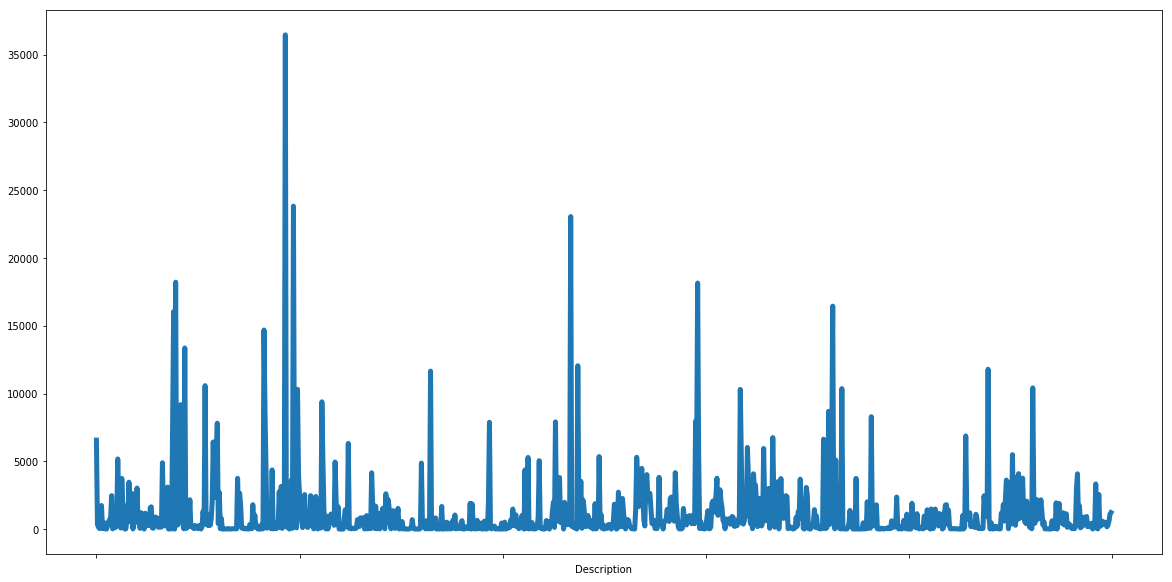

In [86]:
line()